---
title: CryCeleb2023 Diary
from: markdown+emoji
author: "Dien-Hoa Truong"
date: 2023-07-11
categories: [deeplearning, audio]

---

My Experiments to winning the CryCeleb Competition (Audio Verification)

![CryCeleb Competition](https://huggingface.co/Ubenwa/sb-ecapa-vggsound/resolve/main/logo.jpg)

This blog post is to document my journey to winning the [CryCeleb](https://huggingface.co/spaces/competitions/CryCeleb2023) competition hosted by [HuggingFace](https://huggingface.co/) and [Ubenwa](https://www.ubenwa.ai/), which focuses on verifying babies using their cry sound. However, I must admit that:

- I don't track all of my experiments and don't really remember which approach give me this position

Why?

- Initially, my plan was to document all my experiments once I had established a reliable baseline. Unfortunately, this never happened. None of the strategies I used provided me with any significant indication that they were drastically more effective than merely augmenting the host's baseline model with Test Time Augmentation (TTA) (given that the dev set and the public set is quite small)

- Not developing a library in maintaining an organized record of my experiments. As the codebase for my experiments expanded, it became increasingly difficult to manage and track everything.

Advice for future competitions:

- Begin by building a library with [nbdev](https://nbdev.fast.ai/). This will naturally facilitate easier tracking of experiments.

### What I have tried

- Implementing a Siamese Network with Spectrogram Image
- Employing a Siamese Network with an ECAPA model - Contrastive Loss MSE/MAE
- Utilizing a Siamese Network with an ECAPA model - Contrastive Loss for Cosine Similarity
- Applying an ECAPA Network with various hyperparameters and Label Smoothing for the loss function (Final Submission)

During test inference, I employed Test Time Augmentation, randomly pairing 7x7 slices of sound duration ranging from 3s to 15s.

All my experiments, with the exception of the last one, are unsuccessful, as none of them delivered robust metrics on the dev set.

### Siamese Network with Spectrogram Image

Having previously succeeded in an Audio Classification competition, I initiated this challenge using a Siamese Network for an Image Classification approach. This involved converting the audio into a spectrogram image and using a ResNet model as the backbone. However, the results were disappointing.

### Siamese Network with an ECAPA model - Contrastive Loss MSE/MAE

Unable to initially surpass the baseline model, I began experimenting with a Siamese Network in conjunction with the baseline. However, due to a lack of understanding of the inner workings of the ECAPA model, I naively used MAE/MSE as the loss function. Unsurprisingly, the results were quite unsatisfactory.

### Siamese Network with an ECAPA model - Contrastive Loss for Cosine Similarity

After realizing that the ECAPA model was designed to maximize the angle between different classes, I attempted to modify the Contrastive Loss function. Instead of using the MAE/MSE Loss, I employed Cosine Similarity. I had high hopes for this method, but unfortunately, it didn't work. After a few epochs, the loss pushed towards the extreme values of -1 and 1, a phenomenon I still can't explain.

### ECAPA Network with various hyperparameters and Label Smoothing for the loss function

In response to these setbacks, I returned to the baseline model, making some adjustments to the hyperparameters to create a larger model than the baseline, and added label smoothing.

## Final Experiment

In [ ]:
!pip install -qq speechbrain
!pip install -qq seaborn
!pip install -Uqq huggingface_hub
!pip install -Uqq fastai
!pip install -Uqq wandb

In [ ]:
import speechbrain as sb
from speechbrain.pretrained import SpeakerRecognition, EncoderClassifier
from speechbrain.dataio.dataio import read_audio
from speechbrain.utils.metric_stats import EER
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm
import random
from speechbrain.processing.features import InputNormalization
from speechbrain.lobes.features import Fbank
import seaborn as sns
from itertools import combinations, product

In [ ]:
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader

In [ ]:
import wandb
from fastai.callback.wandb import *
wandb.init("cryceleb")

wandb: Currently logged in as: dhoa. Use `wandb login --relogin` to force relogin


In [ ]:
# read metadata
metadata = pd.read_csv(f'metadata.csv', dtype={'baby_id':str, 'chronological_index':str})
dev_metadata = metadata.loc[metadata['split']=='dev'].copy()
# read sample submission
sample_submission = pd.read_csv(f"sample_submission.csv") # scores are unfiorm random
# read verification pairs
dev_pairs = pd.read_csv(f"dev_pairs.csv", dtype={'baby_id_B':str, 'baby_id_D':str})
test_pairs = pd.read_csv(f"test_pairs.csv")

display(metadata.head().style.set_caption(f"metadata").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))
display(dev_pairs.head().style.set_caption(f"dev_pairs").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))
display(test_pairs.head().style.set_caption(f"test_pairs").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))
display(sample_submission.head().style.set_caption(f"sample_submission").set_table_styles([{'selector': 'caption','props': [('font-size', '20px')]}]))

,baby_id,period,duration,split,chronological_index,file_name,file_id
0,0694,B,1.320000,dev,000,audio/dev/0694/B/0694_B_000.wav,0694_B_000
1,0694,B,0.940000,dev,001,audio/dev/0694/B/0694_B_001.wav,0694_B_001
2,0694,B,0.880000,dev,002,audio/dev/0694/B/0694_B_002.wav,0694_B_002
3,0694,B,1.130000,dev,003,audio/dev/0694/B/0694_B_003.wav,0694_B_003
4,0694,B,1.180000,dev,004,audio/dev/0694/B/0694_B_004.wav,0694_B_004


,baby_id_B,baby_id_D,id,label
0,0133,0611,0133B_0611D,0
1,0593,0584,0593B_0584D,0
2,0094,0292,0094B_0292D,0
3,0563,0094,0563B_0094D,0
4,0122,0694,0122B_0694D,0


,baby_id_B,baby_id_D,id
0,anonymous027,anonymous212,anonymous027B_anonymous212D
1,anonymous035,anonymous225,anonymous035B_anonymous225D
2,anonymous029,anonymous288,anonymous029B_anonymous288D
3,anonymous001,anonymous204,anonymous001B_anonymous204D
4,anonymous075,anonymous244,anonymous075B_anonymous244D


,id,score
0,anonymous027B_anonymous212D,0.548814
1,anonymous035B_anonymous225D,0.715189
2,anonymous029B_anonymous288D,0.602763
3,anonymous001B_anonymous204D,0.544883
4,anonymous075B_anonymous244D,0.423655


## Ubenwa Baseline

I reproduced the baseline from code, excluding the config file. This facilitated easier customization of the code according to my needs, and allowed for the use of a more high level framework like `fastai`. The following are some code snippets from `speechbrain` for the `ecapa` model.

In [ ]:
class InputNormalizationFixedSize(InputNormalization):
    def forward(self, x):
        N_batches = x.shape[0]

        current_means = []
        current_stds = []

        for snt_id in range(N_batches):

            # Avoiding padded time steps
            actual_size = torch.round(torch.tensor(1) * x.shape[1]).int()

            # computing statistics
            current_mean, current_std = self._compute_current_stats(
                x[snt_id, 0:actual_size, ...]
            )

            current_means.append(current_mean)
            current_stds.append(current_std)

            if self.norm_type == "sentence":

                x[snt_id] = (x[snt_id] - current_mean.data) / current_std.data
        return x

In [ ]:
normalizer = InputNormalizationFixedSize(norm_type='sentence', std_norm=False)

In [ ]:
feature_maker = Fbank(deltas=False,
                    n_mels=80,
                    left_frames=0,
                    right_frames=0,
                    )

In [ ]:
dataset_path = './'
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
dev_metadata = metadata.loc[metadata["split"] == "dev"].copy()
sample_submission = pd.read_csv(
    f"{dataset_path}/sample_submission.csv"
) 
dev_pairs = pd.read_csv(
    f"{dataset_path}/dev_pairs.csv", dtype={"baby_id_B": str, "baby_id_D": str}
)
test_pairs = pd.read_csv(f"{dataset_path}/test_pairs.csv")

In [ ]:
encoder = SpeakerRecognition.from_hparams(
    source="Ubenwa/ecapa-voxceleb-ft-cryceleb",
    savedir=f"ecapa-voxceleb-ft-cryceleb",
    run_opts={"device":"cuda"} #comment out if no GPU available
)

In [ ]:
embedding_model = encoder.mods.embedding_model

In [ ]:
def shuffle_group_and_concat(x, n=8):
    """ Shuffle sound data per row and concat """
    concatenated_results = []
    for _ in range(n):
        shuffled_values = x.values.copy()
        random.shuffle(shuffled_values)
        concatenated = np.concatenate(shuffled_values)
        tensor_length = concatenated.shape[0]
        
        if tensor_length < 16000*3:
            raw_audio = np.tile(concatenated, math.ceil(16000*7 / tensor_length))

        concatenated = concatenated[:random.randint(16000*3, 16000*15)]
        concatenated_results.append(concatenated)
    return concatenated_results

In [ ]:
def compute_cosine_similarity_score(row, cry_dict):
    """ Average scores for all possible pairs """
    cos = torch.nn.CosineSimilarity(dim=-1)
    encoded_cry_B = cry_dict[(row['baby_id_B'], 'B')]['cry_encoded']
    encoded_cry_D = cry_dict[(row['baby_id_D'], 'D')]['cry_encoded']
    
    similarity_scores = []
    for tensor_B in encoded_cry_B:
        for tensor_D in encoded_cry_D:
            similarity_score = cos(tensor_B, tensor_D)
            similarity_scores.append(similarity_score.item())
    return sum(similarity_scores) / len(similarity_scores)

In [ ]:
dev_metadata = metadata.loc[metadata['split']=='dev'].copy()
dev_metadata['cry'] = dev_metadata.apply(lambda row: read_audio(row['file_name']).numpy(), axis=1)
grouped_data = dev_metadata.groupby(['baby_id', 'period'])['cry']
cry_dict = {}
for key, group in grouped_data:
    cry_dict[key] = {'cry': shuffle_group_and_concat(group, 7)}

In [ ]:
def encode(embedding_model, item):
    """ Encoding audio for ECAPA model including: Feature_maker, Normalizer, Embedding Model """
    is_training = embedding_model.training
    if is_training: embedding_model.eval()
    item = item.unsqueeze(0)
    feats = feature_maker(item.cuda())
    feats = normalizer(feats)
    embeddings = embedding_model(feats)
    
    if is_training: embedding_model.train()
    return embeddings

In [ ]:
def compute_eer_and_plot_verification_scores(pairs_df, plot=True):
    ''' pairs_df must have 'score' and 'label' columns'''
    positive_scores = pairs_df.loc[pairs_df['label']==1]['score'].values
    negative_scores = pairs_df.loc[pairs_df['label']==0]['score'].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    if plot:
        ax = sns.histplot(pairs_df, x='score', hue='label', stat='percent', common_norm=False)
        ax.set_title(f'EER={round(eer, 4)} - Thresh={round(threshold, 4)}')
        plt.axvline(x=[threshold], color='red', ls='--');
        print(eer)
    return eer, threshold


In [ ]:
def get_eer(embedding_model, cry_dict, df, tta_nb = 8, plot=True, ):
    
    embedding_model.eval()
    for key, group in grouped_data:
        cry_dict[key] = {'cry': shuffle_group_and_concat(group, tta_nb)}
    with torch.no_grad():
        embedding_model = embedding_model
        if plot:
            loop = tqdm(cry_dict.items())
        else:
            loop = cry_dict.items()            
        for (baby_id, period), d in loop:
            cry_array = d['cry']
            cry_encoded_list = []
            for row in cry_array:
                encoded_row = encode(embedding_model.cuda(), torch.tensor(row).cuda())
                encoded_row = encoded_row.cpu()
                cry_encoded_list.append(encoded_row)

            d['cry_encoded'] = cry_encoded_list
    df['score'] = dev_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict), axis=1)
    eer, threshold = compute_eer_and_plot_verification_scores(pairs_df=df, plot=plot)
    embedding_model.train()

    return eer, threshold

  0%|          | 0/80 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


0.22499999403953552


(0.22499999403953552, 0.07767139354837127)

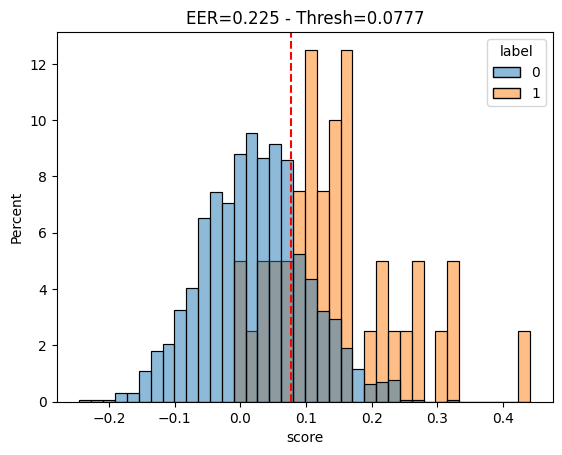

In [ ]:
get_eer(embedding_model, cry_dict, dev_pairs)

## Dataset

In [ ]:
def get_pair_item(item):
    if item.name == 'B':
        pair_name = 'D'
    else:
        pair_name = 'B'
    return item.parent / pair_name

In [ ]:
files = metadata['file_name'].values
folders = [Path(file).parent for file in files]
folders = list(set(folders))

In [ ]:
len(folders)

1334

In [ ]:
def read_audio_from_list(paths):
    raw_audios_aug = []
    random.shuffle(paths)
    raw_audio = torch.concat([read_audio(str(filename)) for filename in paths])
    tensor_length = raw_audio.shape[0]
    if tensor_length < 16000*3:
        raw_audio = raw_audio.repeat(math.ceil(16000*5 / tensor_length))
    return raw_audio

In [ ]:
train_folders = [folder for folder in folders if folder.parent.parent.name in ['train']]
dev_folders = [folder for folder in folders if folder.parent.parent.name in ['dev']]
full_folders = train_folders + dev_folders
pair_folders = [folder for folder in train_folders if get_pair_item(folder).exists()]

In [ ]:
len(full_folders) ,len(train_folders), len(dev_folders), len(pair_folders)

(1014, 934, 80, 696)

In [ ]:
### get both id from train and dev
baby_ids = metadata[(metadata['split'] == 'train')]['baby_id'].unique()
baby_ids = np.sort(baby_ids)
n_classes = len(baby_ids)
print(n_classes)

586


In [ ]:
id2idx = {baby_id: index for index, baby_id in enumerate(baby_ids)}

In [ ]:
files = metadata['file_name'].values
folders = [Path(file).parent for file in files]
folders = list(set(folders))

In [ ]:
full_folders = [folder for folder in folders if folder.parent.parent.name in ['train', 'dev']]
train_folders_pairs = [folder for folder in train_folders if get_pair_item(folder).exists()]
baby_ids_pairs = list(set([folder.parent.name for folder in train_folders_pairs]))
valid_folders = [Path('audio/train')/_id/ random.choice(['B','D']) for _id in baby_ids_pairs ]
train_folders = [folder for folder in train_folders if folder not in valid_folders]

In [ ]:
len(full_folders) ,len(train_folders), len(dev_folders), len(pair_folders)

(1014, 586, 80, 696)

In [ ]:
train_meta = metadata[metadata['split'] == 'train']
dev_meta = metadata[metadata['split'] == 'dev']
test_meta = metadata[metadata['split'] == 'test']

In [ ]:
# train_folders_not_pairs = [folder for folder in train_folders if not get_pair_item(folder).exists()]

In [ ]:
def read_audio_from_folder(folder, shuffle = True):
    if shuffle == True:
        files = [str(filename) for filename in folder.ls().shuffle() if filename.suffix == '.wav']
    else:
        files = [str(filename) for filename in folder.ls() if filename.suffix == '.wav']
    raw_audio = torch.concat([read_audio(str(filename)) for filename in files])
    tensor_length = raw_audio.shape[0]
    if tensor_length < 16000*3:
        raw_audio = raw_audio.repeat(math.ceil(16000*6 / tensor_length))
    return raw_audio

In [ ]:
def get_label(folder):
    return id2idx[folder.parent.name]

In [ ]:
class CryCelebDset(Dataset):
    def __init__(self,
                 items):
        super(CryCelebDset, self).__init__()
        self.items = items
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, i):
        item = self.items[i]
        audio = read_audio_from_folder(item)
        label = get_label(item)
        return audio, torch.Tensor([label]).long()

In [ ]:
def collate_fn(batch):
    audios, labels = zip(*batch)
    target_lenth = min(audio.shape[0] for audio in audios)
    
    target_lenth = target_lenth if target_lenth < 16000*3 else min(target_lenth, random.randint(16000*3, 16000*8))

    audios = [audio[:target_lenth] for audio in audios]
    
    return torch.stack(audios), torch.stack(labels)

In [ ]:
# train_dset = CryCelebDset(train_folders)
train_dset = CryCelebDset(train_folders)
valid_dset = CryCelebDset(train_folders[:2]) # Validation is no use here, it is just a hack to make fastai work

In [ ]:
len(train_dset), len(valid_dset)

(586, 2)

In [ ]:
train_loader = DataLoader(train_dset, batch_size=16, shuffle=True,  collate_fn=collate_fn)
valid_loader = DataLoader(valid_dset, batch_size=32, shuffle=False,  collate_fn=collate_fn)

In [ ]:
dls = DataLoaders(train_loader, valid_loader)

## Model

The model here shares the same architecture as the `ECAPA` model, but there are some differences in the hyperparameters, such as `n_mels = 150, lin_neurons = 250`. My intention was to experiment with a larger version of the default `ECAPA` model.

There is a minor modification in the loss function: I added `label_smoothing` with a value of 0.05.

In [ ]:
import torch.nn.functional as F
from torch import nn

class Classifier(nn.Module):

    def __init__(
        self,
        input_size,
        device="cpu",
        lin_neurons=192,
        out_neurons=1211,
        dropout_rate=0.5,  # add a dropout_rate parameter
    ):

        super().__init__()

        self.linear = nn.Linear(input_size, lin_neurons)
        self.dropout = nn.Dropout(dropout_rate)

        # Final Layer
        self.weight = nn.Parameter(
            torch.FloatTensor(out_neurons, lin_neurons).to(device)
        )
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        x = self.linear(x)
        x = self.dropout(x)

        # Need to be normalized
        x = F.linear(F.normalize(x.squeeze(1)), F.normalize(self.weight))
        return x.unsqueeze(1)


In [ ]:
def is_model_frozen(model):
    return all(not param.requires_grad for param in model.parameters())

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

unfreeze_model(embedding_model)
print(is_model_frozen(embedding_model))  


False


In [ ]:
n_mels = 150
lin_neurons = 250

# n_mels = 80
# lin_neurons = 192

feature_maker = sb.lobes.features.Fbank(deltas=False,
                                        n_mels=n_mels,
                                        left_frames=0,
                                        right_frames=0,
                                        )

embedding_model = sb.lobes.models.ECAPA_TDNN.ECAPA_TDNN(input_size=n_mels,
                                                        channels=[1024, 1024, 1024, 1024, 3072],
                                                        kernel_sizes=[5, 3, 3, 3, 1],
                                                        dilations=[1, 2, 3, 4, 1],
                                                        groups=[1, 1, 1, 1, 1],
                                                        attention_channels=128,
                                                        lin_neurons=lin_neurons
                                                        )

classifier = sb.lobes.models.ECAPA_TDNN.Classifier(input_size=lin_neurons,
                        out_neurons=n_classes,
                      )
class Model(nn.Module):
    def __init__(self, feature_maker, normalizer, embedding_model, classifier):
        super(Model, self).__init__()
        self.feature_maker = feature_maker
        self.normalizer = normalizer
        self.embedding_model = embedding_model
        self.classifier = classifier
    
    def forward(self, x):
        feats = self.feature_maker(x)
        feats = self.normalizer(feats)
        embeddings = self.embedding_model(feats)
        classifier_outputs = self.classifier(embeddings)
        return classifier_outputs
    
model = Model(feature_maker = feature_maker,
              normalizer=normalizer,
              embedding_model=embedding_model,
              classifier=classifier)

In [ ]:
class LogSoftmaxWrapperSmoothing(nn.Module):
    def __init__(self, loss_fn, smoothing=0.05):  # add a smoothing parameter
        super(LogSoftmaxWrapperSmoothing, self).__init__()
        self.loss_fn = loss_fn
        self.criterion = torch.nn.KLDivLoss(reduction="sum")
        self.smoothing = smoothing  # store the smoothing value

    def forward(self, outputs, targets, length=None):
        outputs = outputs.squeeze(1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets.long(), outputs.shape[1]).float()

        # Apply label smoothing
        targets = (1 - self.smoothing) * targets + self.smoothing / outputs.shape[1]

        try:
            predictions = self.loss_fn(outputs, targets)
        except TypeError:
            predictions = self.loss_fn(outputs)

        predictions = F.log_softmax(predictions, dim=1)
        loss = self.criterion(predictions, targets) / targets.sum()
        return loss
    
loss_base = sb.nnet.losses.AdditiveAngularMargin(margin=0.2, scale=30)
crit = LogSoftmaxWrapperSmoothing(loss_base)
def loss_fn(preds, targets):
    return crit(preds, targets)

In [ ]:
def eer_metric(preds, targs):
    # The eer metric here is not related to the validation set but the dev set
    eer, threshold = get_eer(embedding_model, cry_dict, dev_pairs, plot=False)
    return eer

In [ ]:
learner = Learner(dls, model, loss_func=loss_fn, metrics=[eer_metric], cbs=WandbCallback())

SuggestedLRs(valley=9.120108734350652e-05)

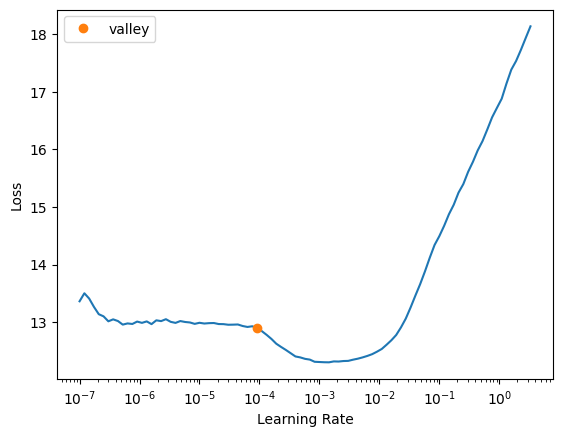

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(150, 2e-4)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'DataLoader' object has no attribute 'new'


epoch,train_loss,valid_loss,eer_metric,time
0,12.819111,9.852398,0.397115,00:21
1,11.732524,9.378596,0.369231,00:20
2,10.952858,6.739351,0.375000,00:19
3,10.304280,8.235709,0.350000,00:18
4,9.576555,6.657913,0.375000,00:18
5,8.874806,7.752380,0.350962,00:18
6,8.028608,4.957489,0.325000,00:17
7,7.302641,5.177752,0.301923,00:17
8,6.496997,4.656638,0.350000,00:17
9,5.806657,5.101495,0.325000,00:17


## Submission

In [ ]:
embedding_model.eval()
test_metadata = metadata.loc[metadata['split']=='test'].copy()
test_metadata['cry'] = test_metadata.apply(lambda row: read_audio(row['file_name']).numpy(), axis=1)
grouped_data = test_metadata.groupby(['baby_id', 'period'])['cry']
cry_dict_test = {}
for key, group in grouped_data:
    cry_dict_test[key] = {'cry': shuffle_group_and_concat(group, 7)}

with torch.no_grad():

    for (baby_id, period), d in tqdm(cry_dict_test.items()):
        cry_array = d['cry']
        cry_encoded_list = []

        for row in cry_array:
            encoded_row = encode(embedding_model.cuda(), torch.tensor(row).cuda())
            cry_encoded_list.append(encoded_row)

        d['cry_encoded'] = cry_encoded_list
    
test_pairs['score'] = test_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict_test), axis=1)

  0%|          | 0/320 [00:00<?, ?it/s]

In [ ]:
#submission must match the 'sample_submission.csv' format exactly
my_submission= test_pairs[['id', 'score']]
my_submission.to_csv('my_submission.csv', index=False)
display(my_submission.head())

,id,score
0,anonymous027B_anonymous212D,-0.120739
1,anonymous035B_anonymous225D,-0.063723
2,anonymous029B_anonymous288D,0.026014
3,anonymous001B_anonymous204D,-0.170518
4,anonymous075B_anonymous244D,0.125677
